# Set ROIs

This notebook allows you to make ROIs for a video without going through the entire pipeline. The example frame used as the image to set the ROIs is fetched using OpenCV's video reader.\
The functionality of this notebook is technically subsumed by the basic pipeline notebook.

**If your data is local**: Just specify the path to the video you want to draw ROIs on.

**If your data is on a server**: OpenCV's video reader allows for you to read just a single frame from a video file without transferring the entire thing IF the server directory is mounted. So we recommend mounting the server directory if possible to avoid transferring the entire file. This can be done with:
- Windows: https://support.microsoft.com/en-us/windows/map-a-network-drive-in-windows-29ce55d1-34e3-a7e2-4801-131475f9557d
- OSX: https://www.google.com/search?q=mount+network+drive+osx
- Linux: Use RClone CLI

In [1]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import face_rhythm as fr

from pprint import pprint
from pathlib import Path

import cv2

import numpy as np
import torch
import matplotlib.pyplot

fr.util.get_system_versions(verbose=True);

Operating System: Linux: 5.15.0-56-generic, #62~20.04.1-Ubuntu SMP Tue Nov 22 21:24:20 UTC 2022, x86_64, node: rich-L-CLASS
Conda Environment: FR
Python Version: 3.9.13
GCC Version: 9.4.0
PyTorch Version: 1.12.0+cu113
CUDA Version: 11.3, CUDNN Version: 8302, Number of Devices: 1, Devices: ['device 0: Name=NVIDIA GeForce RTX 3090, Memory=25.403129856 GB'], 
Numpy Version: 1.21.6
OpenCV Version: 4.6.0
face-rhythm Version: 0.1.0


## Set paths

In [12]:
path_video = r'/mnt/MICROSCOPE/Gyu/BMI_data/20221004_mouse_g1/camera_data/cam3/baseline/cam32022-10-04T13_48_27.avi'
directory_save = r'/home/rich/Desktop/'

## Fetch image

In [13]:
vc = cv2.VideoCapture(path_video)
s, image = vc.read()

# Define ROIs

Either select new ROIs (`select_mode='gui'`), or import existing ROIs (`path_file=path_to_ROIs.h5_file`).\
Typically, you should make 1 or 2 ROIs. One for defining where the face points should be and one for cropping the frame.

FR: Initializing GUI...


<IPython.core.display.Javascript object>


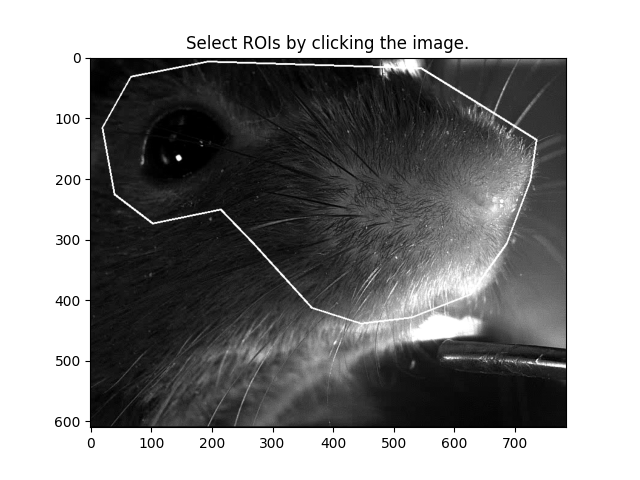

Button(description='Confirm ROI', style=ButtonStyle())

Button(description='New ROI', style=ButtonStyle())

mask_frames computed


In [15]:
# %matplotlib notebook
rois = fr.rois.ROIs(
    select_mode='gui',
    exampleImage=image,
    verbose=2
)

Save the `ROIs` object in the 'analysis_files' project folder

In [5]:
path_save = str(Path(directory_save) / 'ROIs.h5')
rois.save_run_data(path_run_data=path_save, overwrite=True, verbose=1)